In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:
import urllib.request
import tarfile

filename = 'CPHdata.tar.gz'

# دانلود فایل
print('Downloading...')
urllib.request.urlretrieve("https://hbakhshi.web.cern.ch/hbakhshi/IUT/TMP/CPHdata.tar.gz", filename)
print('Download completed.')

# استخراج فایل tar.gz
print('Extracting...')
with tarfile.open(filename, 'r:gz') as tar:
    tar.extractall(path=".")
print('Extraction completed.')

Downloading...
Download completed.
Extracting...


/tmp/ipython-input-1749346778.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=".")


Extraction completed.


In [ ]:
class Config:
    SIGNALS_PATH = './'
    BKG_PATH = './'
    SIGNALS = ['mini_WZ_jjnunu_pT_450_1200_test.h5']
    BKGS = ['mini_QCDjj_pT_450_1200_test.h5']
    IMAGE_SIZE = 32
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-3
    NUM_CLASSES = 2
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    KERNEL_SIZE = 3
    POOL = 2
    PADDING = 1

In [ ]:
def AllFiles():
    ret = []
    for signal in Config.SIGNALS:
        ret.append(Path(Config.SIGNALS_PATH) / signal)
    for bkg in Config.BKGS:
        ret.append(Path(Config.BKG_PATH) / bkg)
    return ret
def GetLabels():
    labels = []
    for signal in Config.SIGNALS:
        labels.append(1)  # Signal class
    for bkg in Config.BKGS:
        labels.append(0)  # Background class
    return labels

In [ ]:
def create_image(pt, mass, charge, eta, phi, size):
    image = np.zeros((size, size, 3), dtype=np.float32)

    min_eta = np.min(eta)
    max_eta = np.max(eta)
    phi     = np.mod(phi + np.pi, 2 * np.pi) - np.pi

    eta_idx = (((eta - min_eta) / (max_eta - min_eta)) * (size - 1)).astype(int)
    phi_idx = (((phi + np.pi) / (2 * np.pi)) * (size - 1)).astype(int)

    for i in range(len(pt)):
        if pt[i] > 0:
            x, y = eta_idx[i], phi_idx[i]
            image[y, x , 0] += pt[i]
            image[y, x , 1] += mass[i]
            image[y, x , 2] += charge[i]

    image[:,:,0] /= np.max(image[:,:,0]) if np.max(image[:,:,0]) > 0 else 1
    image[:,:,1] /= np.max(image[:,:,1]) if np.max(image[:,:,1]) > 0 else 1
    image[:,:,2] /= np.max(image[:,:,2]) if np.max(image[:,:,2]) > 0 else 1

    return image

In [ ]:
class JetImageDataset(Dataset):
    def __init__(self, h5_paths, labels, image_size, n_jets=-1):
        super(JetImageDataset, self).__init__()

        self.pt     = None
        self.eta    = None
        self.phi    = None
        self.mass   = None
        self.charge = None
        self.labels = np.array([])
        for h5_path, lbl in zip(h5_paths, labels):
            if not Path(h5_path).exists():
                raise FileNotFoundError(f"File {h5_path} does not exist.")
            with h5py.File(h5_path, 'r') as f:
                cnsts = f["objects/jets/jet1_cnsts"][:n_jets]
                #jets = f["objects/jets/jet1_obs"][:n_jets]
                if self.pt is None:
                    self.pt     = cnsts[:,:,0]
                    self.eta    = cnsts[:,:,1]
                    self.phi    = cnsts[:,:,2]
                    self.mass   = cnsts[:,:,3]
                    self.charge = cnsts[:,:,4]
                else:
                    self.pt     = np.concatenate([self.pt,      cnsts[:,:,0]])
                    self.eta    = np.concatenate([self.eta,     cnsts[:,:,1]])
                    self.phi    = np.concatenate([self.phi,     cnsts[:,:,2]])
                    self.mass   = np.concatenate([self.mass,    cnsts[:,:,3]])
                    self.charge = np.concatenate([self.charge,  cnsts[:,:,4]])

                njets = cnsts.shape[0]
                self.labels = np.concatenate([self.labels, np.full(njets, lbl)])

        self.image_size = image_size

    def __len__(self):
        return len(self.pt)

    def __getitem__(self, idx):
        image = create_image(
        self.pt[idx],
        self.mass[idx],
        self.charge[idx],
        self.eta[idx],
        self.phi[idx],
        self.image_size
    )
        image = np.transpose(image, (2, 0, 1))  # تبدیل [H, W, C] به [C, H, W]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, config):
        super(CNNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(32 * (config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def train(model, loader, criterion, optimizer, epochs, device, verbose=True):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)
        if verbose:
            print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    return loss_history

In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

[Epoch 1/10] Loss: 0.6991
[Epoch 2/10] Loss: 0.6820
[Epoch 3/10] Loss: 0.6711
[Epoch 4/10] Loss: 0.6553
[Epoch 5/10] Loss: 0.6332
[Epoch 6/10] Loss: 0.6237
[Epoch 7/10] Loss: 0.5928
[Epoch 8/10] Loss: 0.5809
[Epoch 9/10] Loss: 0.5972
[Epoch 10/10] Loss: 0.6016


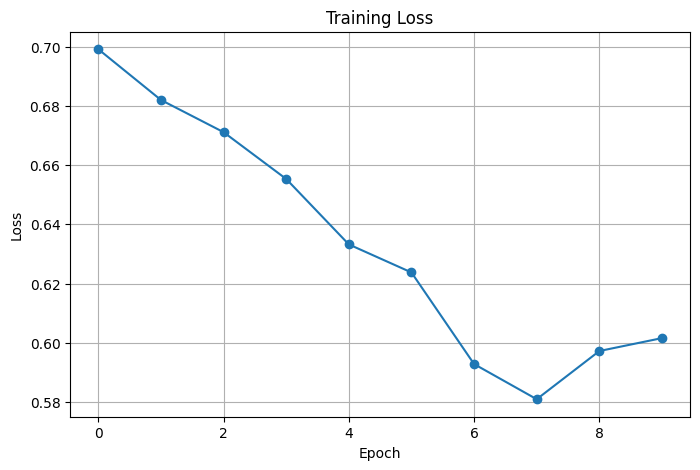

In [ ]:
conf = Config()

dataset = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)

model = CNNClassifier(conf).to(conf.DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=conf.LR)

losses = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE)

plot_losses(losses)

# Network Configuration

In [ ]:
class CNNClassifierArch1(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch1, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(32 * (config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch2(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(32 * (config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch3(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch3, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(16 * (config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch4(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch4, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(16 * (config.IMAGE_SIZE // 4) ** 2, 128), nn.ReLU(),
            nn.Linear(128, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch5(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch5, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(16 * (config.IMAGE_SIZE // 4) ** 2, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch6(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch6, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(16 * (config.IMAGE_SIZE // 4) ** 2, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 8), nn.ReLU(),
            nn.Linear(8, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
conf = Config()
conf.EPOCHS = 100

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)
criterion  = nn.CrossEntropyLoss()

templates = [CNNClassifierArch1, CNNClassifierArch2, CNNClassifierArch3, CNNClassifierArch4, CNNClassifierArch5, CNNClassifierArch6]
losses    = []

for template in templates:
    model = template(conf).to(conf.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=conf.LR)

    loss = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)

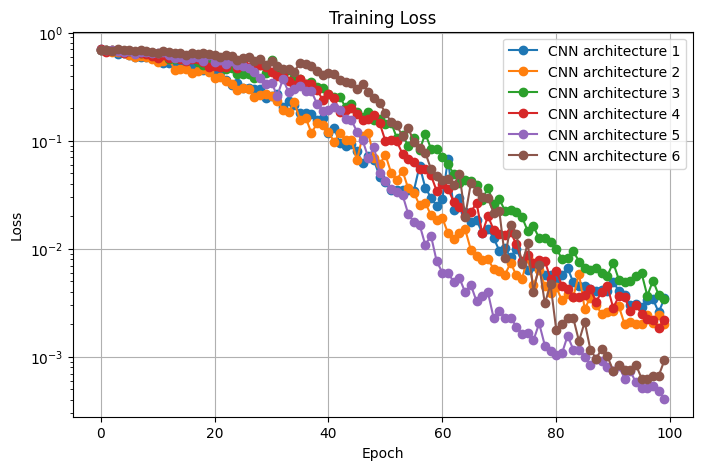

In [ ]:
plt.figure(figsize=(8, 5))

for i in range(6):
    plt.semilogy(losses[i], marker='o', label="CNN architecture {}".format(i+1))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Kernel Size

In [ ]:
class CNNClassifierArch7(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch7, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(64 * 9, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 8), nn.ReLU(),
            nn.Linear(8, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch8(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch8, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(64 * 4, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 8), nn.ReLU(),
            nn.Linear(8, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)


class CNNClassifierArch9(nn.Module):
    def __init__(self, config):
        super(CNNClassifierArch9, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(16, 32, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Conv2d(32, 64, kernel_size=config.KERNEL_SIZE, padding=config.PADDING), nn.ReLU(),
            nn.MaxPool2d(config.POOL),
            nn.Flatten(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, 4), nn.ReLU(),
            nn.Linear(4, config.NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
conf = Config()
conf.EPOCHS = 60

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)
criterion  = nn.CrossEntropyLoss()

templates    = [CNNClassifierArch6, CNNClassifierArch6, CNNClassifierArch7, CNNClassifierArch8, CNNClassifierArch9]
kernel_sizes = [2, 3, 4, 5, 6]
losses       = []
for template, kernel_size in zip(templates, kernel_sizes):
    conf.KERNEL_SIZE = kernel_size
    model = template(conf).to(conf.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=conf.LR)

    loss = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)
    print("model {} complete".format(kernel_size - 1))

model 1 complete
model 2 complete
model 3 complete
model 4 complete
model 5 complete


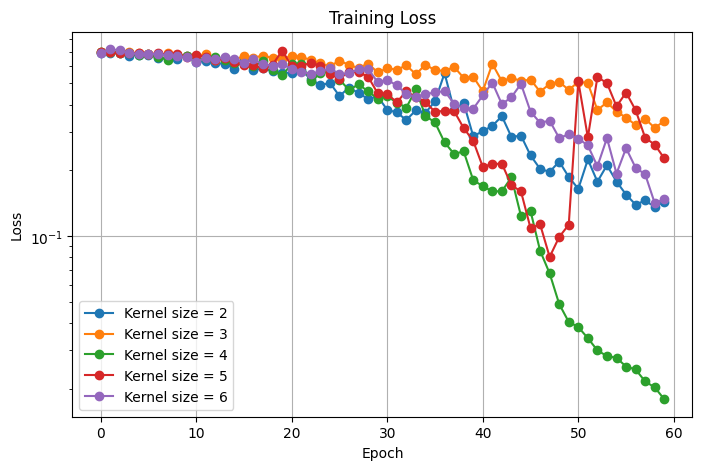

In [ ]:
plt.figure(figsize=(8, 5))

for i in kernel_sizes:
    plt.semilogy(losses[i-2], marker='o', label="Kernel size = {}".format(i))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Optimizer

In [ ]:
conf = Config()
conf.EPOCHS = 60
conf.KERNEL_SIZE = 4

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)
criterion  = nn.CrossEntropyLoss()

optimizers = [optim.Adam, optim.RAdam, optim.NAdam, optim.SGD, optim.ASGD, optim.Rprop, optim.RMSprop, optim.Adadelta, optim.Adafactor, optim.Adagrad]
losses     = []
for i, optimizer in enumerate(optimizers):
    model     = CNNClassifierArch7(conf).to(conf.DEVICE)
    optimizer = optimizer(model.parameters(), lr=conf.LR)

    loss = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)
    print("model {} complete".format(i + 1))

model 1 complete
model 2 complete
model 3 complete
model 4 complete
model 5 complete
model 6 complete
model 7 complete
model 8 complete
model 9 complete
model 10 complete


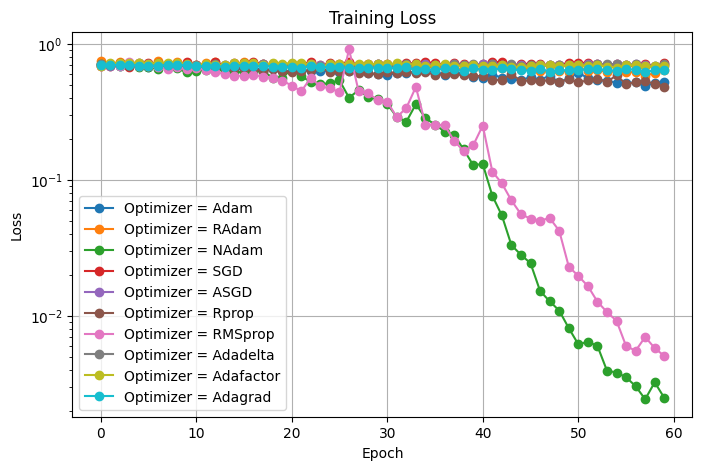

In [ ]:
plt.figure(figsize=(8, 5))

for i, optimizer in enumerate(optimizers):
    plt.semilogy(losses[i], marker='o', label="Optimizer = {:s}".format(optimizer.__name__))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Learning rate

In [ ]:
conf = Config()
conf.EPOCHS = 60
conf.KERNEL_SIZE = 4

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)
criterion  = nn.CrossEntropyLoss()

learning_rates = np.logspace(-5, -2, 10)
losses         = []
for i, lr in enumerate(learning_rates):
    conf.LR   = lr
    model     = CNNClassifierArch7(conf).to(conf.DEVICE)
    optimizer = optim.NAdam(model.parameters(), lr=conf.LR)

    loss = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)
    print("model {} complete".format(i + 1))

model 1 complete
model 2 complete
model 3 complete
model 4 complete
model 5 complete
model 6 complete
model 7 complete
model 8 complete
model 9 complete
model 10 complete


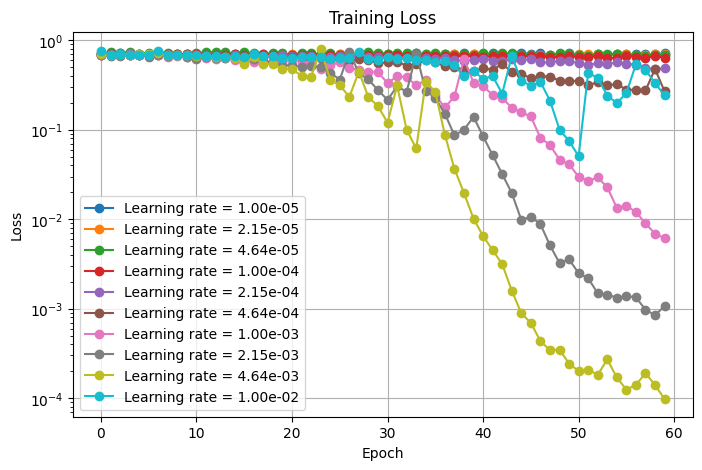

In [ ]:
plt.figure(figsize=(8, 5))

for i, lr in enumerate(learning_rates):
    plt.semilogy(losses[i], marker='o', label="Learning rate = {:.2e}".format(lr))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
conf = Config()
conf.EPOCHS = 60
conf.KERNEL_SIZE = 4

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)
criterion  = nn.CrossEntropyLoss()

learning_rates = np.linspace(0.001, 0.01, 10)
losses         = []
for i, lr in enumerate(learning_rates):
    conf.LR   = lr
    model     = CNNClassifierArch7(conf).to(conf.DEVICE)
    optimizer = optim.NAdam(model.parameters(), lr=conf.LR)

    loss = train(model, dataloader, criterion, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)
    print("model {} complete".format(i + 1))

model 1 complete
model 2 complete
model 3 complete
model 4 complete
model 5 complete
model 6 complete
model 7 complete
model 8 complete
model 9 complete
model 10 complete


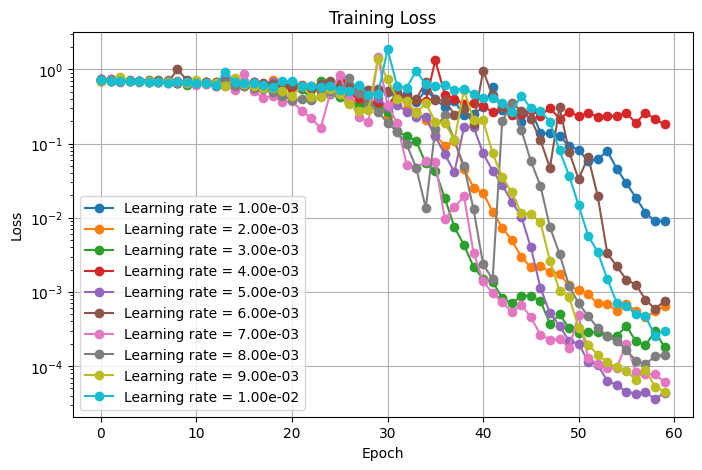

In [ ]:
plt.figure(figsize=(8, 5))

for i, lr in enumerate(learning_rates):
    plt.semilogy(losses[i], marker='o', label="Learning rate = {:.2e}".format(lr))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Loss function

In [ ]:
conf = Config()
conf.EPOCHS = 60
conf.KERNEL_SIZE = 4
conf.lr = 7e-3

dataset    = JetImageDataset(AllFiles(), GetLabels(), conf.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True)

criteria = [nn.BCEWithLogitsLoss, nn.MultiMarginLoss, nn.CrossEntropyLoss]
losses   = []
for i, criterion in enumerate(criteria):
    model     = CNNClassifierArch7(conf).to(conf.DEVICE)
    optimizer = optim.NAdam(model.parameters(), lr=conf.LR)

    cri = criterion()
    loss = train(model, dataloader, cri, optimizer, conf.EPOCHS, conf.DEVICE, verbose=False)
    losses.append(loss)
    print("model {} complete".format(i + 1))

ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 2]))

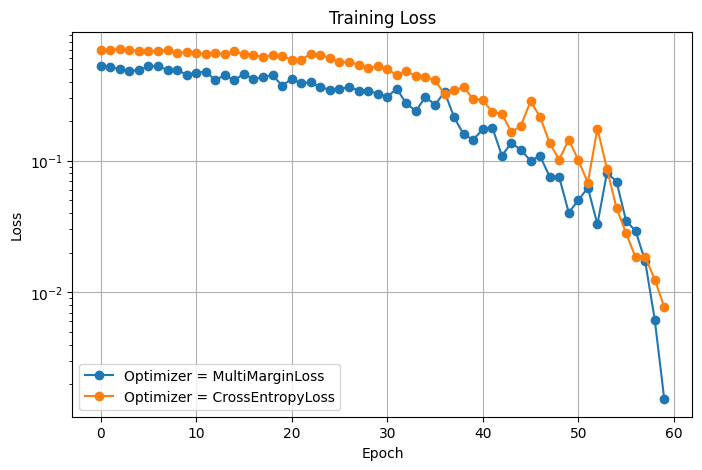

In [ ]:
plt.figure(figsize=(8, 5))

for i, criterion in enumerate(criteria):
    plt.semilogy(losses[i], marker='o', label="Optimizer = {:s}".format(criterion.__name__))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()